In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [3]:
# Load cleaned returns
df_5 = pd.read_csv('../data/sp100_selected_data_5.csv', index_col=0, parse_dates=True)
df_10 = pd.read_csv('../data/sp100_selected_data_10.csv', index_col=0, parse_dates=True)
df_15 = pd.read_csv('../data/sp100_selected_data_15.csv', index_col=0, parse_dates=True)
df_20 = pd.read_csv('../data/sp100_selected_data_20.csv', index_col=0, parse_dates=True)

/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_25613/2983338250.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_5 = pd.read_csv('../data/sp100_selected_data_5.csv', index_col=0, parse_dates=True)
/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_25613/2983338250.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_10 = pd.read_csv('../data/sp100_selected_data_10.csv', index_col=0, parse_dates=True)
/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_25613/2983338250.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_15 = pd.read_csv(

In [29]:
df = df_20
df = df.apply(pd.to_numeric, errors='coerce').fillna(method='ffill').fillna(method='bfill')
daily_returns = df.pct_change().dropna()

/var/folders/tt/1wm0x7wj6sg2zfqbrjhzrtrc0000gn/T/ipykernel_25613/781665345.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.apply(pd.to_numeric, errors='coerce').fillna(method='ffill').fillna(method='bfill')


In [30]:
# Fix column names
def strip_suffix(name):
    return name.split('.')[0].strip().upper()
daily_returns.columns = [strip_suffix(c) for c in daily_returns.columns]
daily_returns = daily_returns.loc[:, ~daily_returns.columns.duplicated()]

# Selected stocks
ticker_5 = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ']
ticker_10 = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'XOM', 'NVDA', 'PG', 'UNH']
ticker_15 = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'XOM', 'NVDA', 'PG', 'UNH', 'TSM', 'WMT', 'VZ', 'V', 'WBA']
ticker_20 = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JNJ', 'JPM', 'XOM', 'NVDA', 'PG', 'UNH', 'TSM', 'WMT', 'VZ', 'V', 'WBA', 'TSLA', 'NFLX', 'ORCL', 'QCOM', 'IBM']

selected_stocks = ticker_20
returns = daily_returns[selected_stocks].mean()

# Target return: same as AMPL version
target_return = returns.mean()

print("📊 Avg returns:\n", returns)
print(f"\n🎯 Target return: {target_return:.6f}")


📊 Avg returns:
 AAPL     0.001104
MSFT    -0.000372
AMZN     0.000351
GOOGL    0.000279
JNJ      0.000343
JPM      0.000910
XOM      0.000270
NVDA     0.001267
PG       0.000310
UNH      0.000447
TSM      0.001084
WMT      0.001487
VZ       0.000655
V        0.000853
WBA     -0.001719
TSLA     0.002306
NFLX     0.001854
ORCL     0.000741
QCOM    -0.000131
IBM      0.001224
dtype: float64

🎯 Target return: 0.000663


In [31]:
# --- GA Configuration ---
NUM_STOCKS = len(returns)
POP_SIZE = 100
NUM_GENERATIONS = 200
MUTATION_RATE = 0.1

In [32]:
# --- Fitness Function ---
def tracking_error(weights, returns, target):
    portfolio_return = np.dot(weights, returns)
    return abs(portfolio_return - target)

# --- Generate initial population (random weight vectors summing to 1) ---
def init_population(size, num_assets):
    pop = []
    for _ in range(size):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]
        pop.append(weights)
    return np.array(pop)

# --- Tournament selection ---
def select_parents(pop, fitnesses):
    idx1, idx2 = random.sample(range(len(pop)), 2)
    return pop[idx1] if fitnesses[idx1] < fitnesses[idx2] else pop[idx2]

# --- Simulated Binary Crossover (SBX-style) ---
def crossover(p1, p2):
    alpha = np.random.rand()
    child = alpha * p1 + (1 - alpha) * p2
    return child / child.sum()

# --- Mutation ---
def mutate(weights, rate=0.1):
    if random.random() < rate:
        idx = random.randint(0, len(weights)-1)
        weights[idx] += np.random.normal(0, 0.05)
        weights = np.clip(weights, 0, None)
        return weights / weights.sum()
    return weights


In [33]:
# --- GA Loop ---
population = init_population(POP_SIZE, NUM_STOCKS)
best_solution = None
best_error = float('inf')

In [34]:
for gen in range(NUM_GENERATIONS):
    fitnesses = [tracking_error(w, returns, target_return) for w in population]
    new_pop = []

    for _ in range(POP_SIZE):
        p1 = select_parents(population, fitnesses)
        p2 = select_parents(population, fitnesses)
        child = crossover(p1, p2)
        child = mutate(child, MUTATION_RATE)
        new_pop.append(child)

    population = np.array(new_pop)

    # Track best
    min_err_idx = np.argmin(fitnesses)
    if fitnesses[min_err_idx] < best_error:
        best_error = fitnesses[min_err_idx]
        best_solution = population[min_err_idx]

    if gen % 25 == 0 or gen == NUM_GENERATIONS - 1:
        print(f"Gen {gen:3} | Best tracking error: {best_error:.8f}")

# --- Results ---
weights_df = pd.Series(best_solution, index=selected_stocks)
print("\n📊 Best Portfolio Weights (GA):")
print(weights_df.round(4))
print(f"\n🎯 Final Tracking Error: {best_error:.8f}")

Gen   0 | Best tracking error: 0.00000123
Gen  25 | Best tracking error: 0.00000000
Gen  50 | Best tracking error: 0.00000000
Gen  75 | Best tracking error: 0.00000000
Gen 100 | Best tracking error: 0.00000000
Gen 125 | Best tracking error: 0.00000000
Gen 150 | Best tracking error: 0.00000000
Gen 175 | Best tracking error: 0.00000000
Gen 199 | Best tracking error: 0.00000000

📊 Best Portfolio Weights (GA):
AAPL     0.0496
MSFT     0.0487
AMZN     0.0420
GOOGL    0.0616
JNJ      0.0558
JPM      0.0604
XOM      0.0606
NVDA     0.0592
PG       0.0371
UNH      0.0752
TSM      0.0403
WMT      0.0322
VZ       0.0538
V        0.0457
WBA      0.0303
TSLA     0.0295
NFLX     0.0470
ORCL     0.0651
QCOM     0.0463
IBM      0.0596
dtype: float64

🎯 Final Tracking Error: 0.00000000


✅ GA weights saved to: ../data/ga_portfolio_weights.csv


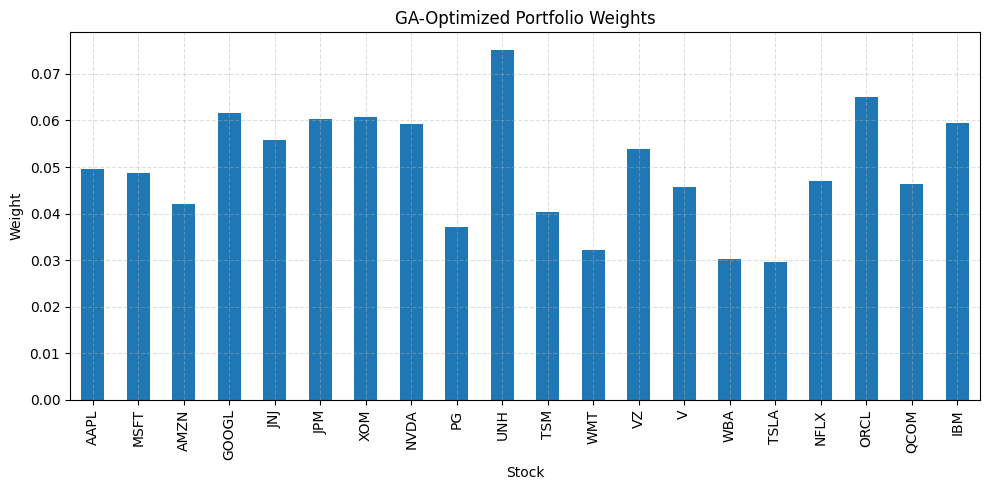

In [35]:
# Save GA-optimized weights to CSV
weights_df.to_csv("../data/ga_portfolio_weights.csv", header=["Weight"])

print("✅ GA weights saved to: ../data/ga_portfolio_weights.csv")


weights_df.plot(kind='bar', figsize=(10, 5), title='GA-Optimized Portfolio Weights')
plt.ylabel("Weight")
plt.xlabel("Stock")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
